In [1]:
import os
import sys
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
os.getcwd()
os.listdir()

['5_10kb_plot_J2.ipynb',
 '.Rhistory',
 'js1_bi.csv',
 'BreakPointDistance.csv',
 'Bipartite_graph.ipynb',
 'Junction_Sequences_NTRK1_nonCRC_4_19_20_deid.xlsx',
 '.DS_Store',
 'Table1.rds',
 'data_Junction_Regions_CRC_4_19_20_deid.fa',
 '5_10kb_plot_J1.ipynb',
 'nonCRC_Table1.pkl',
 'Fusion_Gene_ NTRK1_partners.ipynb',
 'Genome Screenshots',
 'Fusion_Gene_nonCRC.ipynb',
 'Junction_Sequences_CRC_4_19_20_deid.xlsx',
 'js1_count.pkl',
 'Bed_files_for_USCS_plot.ipynb',
 '.RData',
 'nonCRC_gene1_bed',
 'CRC_gene1_bed',
 'Table1.pkl',
 'CRC_gene2_bed',
 '.ipynb_checkpoints',
 'humanFreq.png',
 'CRC_gene1_bed.zip',
 'Fusion_Gene_R.ipynb',
 'Fusion_Gene_CRC.ipynb',
 'MSS_MSI_review.pptx',
 'Re__Windows_in_oncogenic_gene..zip',
 'Fusion_Gene_R.R',
 'data_Junction_Regions_CRC_4_19_20_deid_J2.fa',
 'CeCe_Proj']

# GC content related functions

In [8]:
def cound_mononucleotide(i):
    A_ct = i.count('A') + i.count('a')
    T_ct = i.count('T') + i.count('t')
    C_ct = i.count('C') + i.count('c')
    G_ct = i.count('G') + i.count('g')
    tmp = {'A':A_ct, 'T':T_ct, 'C':C_ct,'G':G_ct}
    return tmp
def count_mono_series(indexed):
    save = {}
    for i in range(len(indexed)):
        save[indexed.index[i]] = cound_mononucleotide(indexed[i])
    return save


def my_referse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return "".join(complement.get(base, base) for base in reversed(seq))
def combine_rc_percentage(dg):
    df = dg.copy()
    df['count'] = df.sum(axis=1)
    cols_rest = list(df.columns)
    cols_1 = []
    cols_2 = []
    for i in df.columns:
        reverse_tmp = my_referse_complement(i)
        if reverse_tmp in list(df.columns):
            cols_rest.remove(i)
            if reverse_tmp not in cols_1:
                cols_1.append(i)
                cols_2.append(reverse_tmp)   
    dt = pd.DataFrame()
    #cols_c = []
    for i,j in zip(cols_1,cols_2):
        if i==j:
            #cols_c.append(i)
            dt[i] = df[i]/df['count']
        else:
            k = i+"+"+j
            #cols_c.append(k)
            dt[k] = (df[i]+df[j])/df['count']           
    dt = pd.concat([dt, df[cols_rest]], axis=1)
    return dt

# Window related functions

In [9]:
def rough_any_bp(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] = tmp.iloc[:,1].str.slice(centre-wing-1, centre+wing)
    tmp.drop(tmp.columns[1],axis=1,inplace = True)
    return tmp
def rough_any_bp_GC(df, wing=2, centre=51):
    tmp = df.copy()
    bp = wing*2 + 1
    tmp["{}bp".format(bp)] = tmp.iloc[:,1].str.slice(centre-wing-1, centre+wing)
    count = count_mono_series(tmp.iloc[:,2])
    tmp = pd.concat([pd.DataFrame(count).T, tmp['IDs']], axis=1)
    tmp = combine_rc_percentage(tmp)
    return tmp.iloc[:,1:3]

def Split_IDs(df):
    dt = df.copy()
    # Drop MSI ambiguous records
    dt = dt[ ~ dt["IDs"].str.endswith('MSI')] # inverting (~) boolean mask
    # Split - Vectorized string functions for Series and Index
    dt[['Chr','Pos','ID1', 'ID2','MSIstatus','Junction','Gene']] = dt.IDs.str.split(':', expand=True)
    dt = dt.drop(columns = 'IDs')
    return dt

# Build windows and get GC content

In [10]:
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    Seqs = pd.Series([str(record.seq) for record in SeqIO.parse(handle,"fasta")])
with open("data_Junction_Regions_CRC_4_19_20_deid_J2.fa") as handle:
    IDs = pd.Series([record.id for record in SeqIO.parse(handle,"fasta")])
J2_tbl = pd.DataFrame({'IDs': IDs, "50+1+50": Seqs})
J2_tbl.head()

,IDs,50+1+50
0,chr7:140489380-140489480:XRN:DNF6WD:MSS:J2:G1,ACTTTCCATTCTTGAGAGCTTACAATCTCATGGGAAGTAAGATGCA...
1,chr7:138253043-138253143:XRN:DNF6WD:MSS:J2:G2,TTTTTAGTAGAGACTGGGTTTCACCGTGTTAGCCAGGATGGTCTCA...
2,chr10:43607709-43607809:XRN:E3F52H:MSI,GCGATGGCACCGGTGGAAACGGGGTCCTGGGGCCCTGCCAGCCTGG...
3,chr10:51587649-51587749:XRN:E3F52H:MSI,GATGTTTTATTAGCAAACATGAAAACATTAATCTCCTTCTGCATCT...
4,chr1:156843298-156843398:XRN:AFAEVN:MSI-H:J2:G1,CCTGTTTCTCCCAGGCCTGCCCTTTGATTTCGGGTTCTACTCGCTT...


In [12]:
J2_5bp_percentage = rough_any_bp_GC(J2_tbl)
split5 = Split_IDs(J2_5bp_percentage)
split5.tail()

,C+G,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene
181,0.4,chr7,55870523-55870623,XRN,NQJ1G5,MSS,J2,G2
182,0.6,chr10,43610209-43610309,XRN,QU97T3,MSS,J2,G1
183,0.2,chr10,51585506-51585606,XRN,QU97T3,MSS,J2,G2
184,0.6,chr7,140482496-140482596,XRN,CFTDTX,MSS,J2,G1
185,0.0,chr3,194325683-194325783,XRN,CFTDTX,MSS,J2,G2


In [13]:
J2_21bp_percentage = rough_any_bp_GC(J2_tbl, wing=10)
split21 = Split_IDs(J2_21bp_percentage)
split21.tail()

,C+G,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene
181,0.238095,chr7,55870523-55870623,XRN,NQJ1G5,MSS,J2,G2
182,0.714286,chr10,43610209-43610309,XRN,QU97T3,MSS,J2,G1
183,0.476190,chr10,51585506-51585606,XRN,QU97T3,MSS,J2,G2
184,0.333333,chr7,140482496-140482596,XRN,CFTDTX,MSS,J2,G1
185,0.523810,chr3,194325683-194325783,XRN,CFTDTX,MSS,J2,G2


In [16]:
J2_1bp_percentage = rough_any_bp_GC(J2_tbl, wing=0)
split1 = Split_IDs(J2_1bp_percentage)
split1.tail()

,C+G,Chr,Pos,ID1,ID2,MSIstatus,Junction,Gene
181,0.0,chr7,55870523-55870623,XRN,NQJ1G5,MSS,J2,G2
182,0.0,chr10,43610209-43610309,XRN,QU97T3,MSS,J2,G1
183,0.0,chr10,51585506-51585606,XRN,QU97T3,MSS,J2,G2
184,1.0,chr7,140482496-140482596,XRN,CFTDTX,MSS,J2,G1
185,0.0,chr3,194325683-194325783,XRN,CFTDTX,MSS,J2,G2


# Group by Gene and boxplot by MSIstatus

G1         AxesSubplot(0.1,0.15;0.363636x0.75)
G2    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

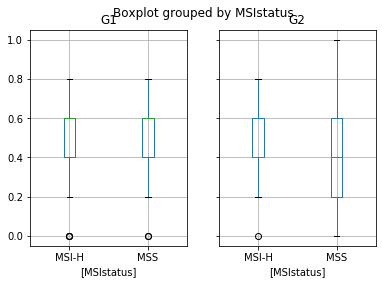

In [14]:
split5.groupby('Gene').boxplot(by = 'MSIstatus')

In [38]:
split5.groupby(["Junction", "Gene","MSIstatus"])['C+G'].agg([np.mean, np.std, np.size, np.sum])

mean       std  size   sum
Junction Gene MSIstatus                                
J2       G1   MSI-H      0.510638  0.219915  47.0  24.0
              MSS        0.511111  0.215557  45.0  23.0
         G2   MSI-H      0.442553  0.181473  47.0  20.8
              MSS        0.417778  0.244288  45.0  18.8

G1         AxesSubplot(0.1,0.15;0.363636x0.75)
G2    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

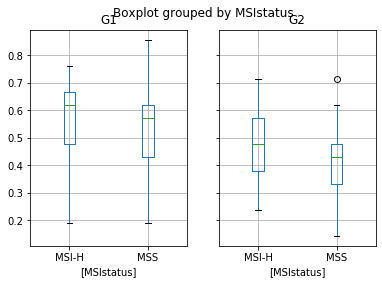

In [15]:
split21.groupby('Gene').boxplot(by = 'MSIstatus')

In [37]:
split21.groupby(["Junction", "Gene","MSIstatus"])['C+G'].agg([np.mean, np.std, np.size, np.sum])

mean       std  size        sum
Junction Gene MSIstatus                                     
J2       G1   MSI-H      0.551165  0.147189  47.0  25.904762
              MSS        0.536508  0.151404  45.0  24.142857
         G2   MSI-H      0.482270  0.125446  47.0  22.666667
              MSS        0.403175  0.138684  45.0  18.142857

G1         AxesSubplot(0.1,0.15;0.363636x0.75)
G2    AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

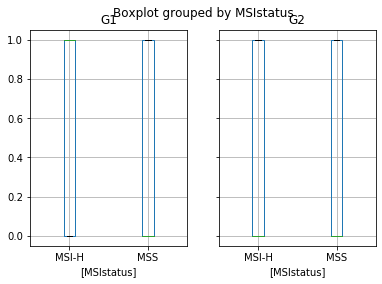

In [17]:
split1.groupby('Gene').boxplot(by = 'MSIstatus')

In [36]:
split1.groupby(["Junction", "Gene","MSIstatus"])['C+G'].agg([np.mean, np.std, np.size, np.sum])

mean       std  size   sum
Junction Gene MSIstatus                                
J2       G1   MSI-H      0.510638  0.505291  47.0  24.0
              MSS        0.488889  0.505525  45.0  22.0
         G2   MSI-H      0.361702  0.485688  47.0  17.0
              MSS        0.422222  0.499495  45.0  19.0